# SRE ReAct agent with custom schema and RAG (to store and fetch incident)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl and prometheus tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Query similar past incidents** during diagnosis using ChromaDB RAG to identify recurring issues and leverage historical knowledge
- **Generate structured diagnosis** with detailed reasoning and root cause analysis, informed by previous similar incidents
- **Create intelligent mitigation plans** by searching ChromaDB for existing solutions or generating new ones for novel issues
- **Store new incidents** automatically in the vector database for future reference and continuous learning
- **Provide comprehensive reports** with step-by-step remediation guidance based on both current analysis and historical patterns

In [172]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [173]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [174]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.peek()

{'ids': ['1cb648e0-a0bf-4937-bce6-1913655b9129',
  '1606b060-881f-4c32-93fa-b79fbe061915',
  '5999b494-e9db-42ee-8e99-1d1a13e0f665'],
 'embeddings': array([[ 0.04610621, -0.01096706,  0.03450377, ..., -0.05895832,
         -0.04106819, -0.00876775],
        [ 0.04610621, -0.01096706,  0.03450377, ..., -0.05895832,
         -0.04106819, -0.00876775],
        [ 0.05709229, -0.00833768,  0.02372634, ..., -0.02605905,
         -0.0344098 , -0.02619601]], shape=(3, 384)),
 'documents': ['# 📝 Results of the Analysis\n\n## 🩺 Symptoms\n- geo pod in CrashLoopBackOff with ~12 restarts (container hotel-reserv-geo)\n- Last container termination Exit Code 2 after ~10s runtime\n- Container logs show panic: "no reachable servers" while initializing DB connection to mongodb-geo:27777\n- mongodb-geo pod is Running and exposes MongoDB on container port 27017 (launched with --auth)\n- Service mongodb-geo exists as ClusterIP in namespace test-hotel-reservation\n- Image pulls for geo succeed (application r

## Building SRE ReAct agent

In [175]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [176]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

prometheus_URL = os.environ.get("PROMETHEUS_SERVER_URL")

client = MultiServerMCPClient(
    {
        "kubernetes" : { # https://github.com/Flux159/mcp-server-kubernetes
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": { # https://github.com/chroma-core/chroma-mcp
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        },
        "prometheus": { # https://github.com/idanfishman/prometheus-mcp
            "command": "npx",
            "args": ["prometheus-mcp@latest", "stdio"],
            "transport": "stdio",
            "env": {
                "PROMETHEUS_URL": str(prometheus_URL)
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [177]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents
🔧 prometheus_list_metrics
🔧 prometheus_metric_metadata
🔧 prometheus_list_labels
🔧 prometheus_label_values
🔧 prometheus_list_targets
🔧 prometheus_scrape_pool_targets
🔧 prometheus_runtime_info
🔧 prometheus_build_info
🔧 prometheus_query
🔧 prometheus_query_range


In [178]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

k8s_tools = []
chroma_tools = []
prometheus_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        k8s_tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)
    # Create a custom list of Prometheus tools
    elif "prometheus" in tool.name:
        prometheus_tools.append(tool)
    

In [179]:
# List of kubernetes tools
for tool in k8s_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [180]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [181]:
# List of prometheus tools
for tool in prometheus_tools:
    print(f"🔧 {tool.name} : {tool.description}")

🔧 prometheus_list_metrics : List all available Prometheus metrics
🔧 prometheus_metric_metadata : Get metadata for a specific Prometheus metric
🔧 prometheus_list_labels : List all available Prometheus labels
🔧 prometheus_label_values : Get all values for a specific Prometheus label
🔧 prometheus_list_targets : List all Prometheus targets
🔧 prometheus_scrape_pool_targets : Get targets for a specific scrape pool
🔧 prometheus_runtime_info : Get Prometheus runtime information
🔧 prometheus_build_info : Get Prometheus build information
🔧 prometheus_query : Execute a Prometheus query
🔧 prometheus_query_range : Execute a Prometheus range query


In [182]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    symptoms: List[str]
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    has_already_happened: bool

In [183]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster and prometheus server.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    1. At the beginning (no insights neither prev steps), start by checking containers for errors using Kubernetes and Prometheus tools, and use the *Previous Steps* and *Insights* to gather the necessary context. Do not perform unnecessary tool calls.
    2. Once you have a concise list of discovered symptoms, use the tool 'chroma_query_documents' to search for the most similar document in the "incidents" collection (query using only the list of symptoms; ask for 1 document only). You must execute the chroma_query_documents tool only once per investigation.
    3. Check the *Previous Steps* section: If you see that a chroma_query_documents call was already made and it did not return a matching document, it means there are no documents with similar incidents in storage. In this case, continue the analysis to identify the issue and do not call chroma_query_documents again.
    4. If a document is returned (there's a similiar previous incident), check the incident report to see if the error is the same as the one you are investigating. IMPORTANT: Make at most one query!
        - If it is the same, proceed to call the submit_final_diagnosis tool as described below.
        - If it is NOT the same, continue further analysis to identify the issue.
    5. When you are ready to conclude your investigation, call the submit_final_diagnosis tool with:
        - diagnosis: Describe the issue you have identified (without fixing it)
        - reasoning: Explain your reasoning and thought process behind the solution
        - symptoms: Concise but exhaustive list of symptoms found (not the solution, just the objective symptoms)

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [184]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. (insight) Review the latest two messages and extract the single most important new insight relevant to incident diagnosis or mitigation. Summarize this insight concisely. If you find any symptoms describe it in this field
    2. (prev_step) Provide a concise description of only the most recent action taken, including the tool used (do not list all previous actions—just the most recent one).
    3. Avoid repeating previously captured steps or insights unless there have been material changes. Append only new, non-duplicate information.
"""

In [185]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"
    
def get_symptoms_str(state):
    """Return a string with the formatted list of symptoms discovered during exploration"""
    if len(state["symptoms"]) > 0:
        return "\n- ".join([""] + state["symptoms"])
    else:
        return "No symptoms discovered"

### Extract insights node

In [186]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [187]:
llm_with_struct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [188]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_struct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [ ]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    symptoms: List[str],
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "symptoms": symptoms,
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
# Grant access to ChromaDB tools for previous incident lookup
sre_agent_tools = k8s_tools + prometheus_tools + [completion_tool] + chroma_tools

In [190]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(sre_agent_tools, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [191]:
sre_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [192]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)
    symptoms_str = get_symptoms_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Symptoms
    message += "## 🩺 Symptoms\n"
    message += symptoms_str.strip() + "\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [193]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [194]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [195]:
mitigation_agent_tools = k8s_tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [196]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "has_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

In [197]:
async def store_incident_report(state: SREAgentState):
    """Store the incident report with the mitigation plan in chromaDB incidents collection"""

    from chromadb import PersistentClient
    import uuid

    chroma_client = PersistentClient(path=chromaDB_path)

    incidents_collection = chroma_client.get_or_create_collection("incidents")

    incidents_collection.add(
        ids=[str(uuid.uuid4())],
        documents=state["final_output"],
    )

    return {}

### Assemble the graph

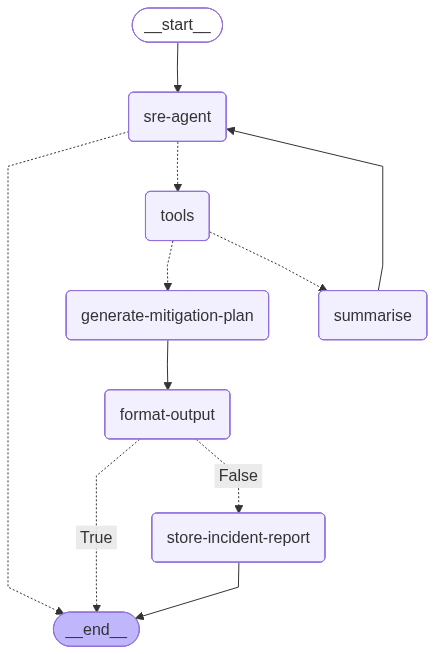

In [198]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(sre_agent_tools)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)
builder.add_node("store-incident-report", store_incident_report)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# If is a new incident, store in VectorDB
def has_already_happened(state: SREAgentState):
    return bool(state['has_already_happened'])
    
builder.add_conditional_edges(
    "format-output",
    has_already_happened,
    {
        True: END,
        False: "store-incident-report"
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)
builder.add_edge("store-incident-report", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [199]:
print(structured_graph.get_graph(xray=True).draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	sre-agent(sre-agent)
	tools(tools)
	summarise(summarise)
	generate-mitigation-plan(generate-mitigation-plan)
	format-output(format-output)
	store-incident-report(store-incident-report)
	__end__([<p>__end__</p>]):::last
	__start__ --> sre-agent;
	format-output -. &nbsp;True&nbsp; .-> __end__;
	format-output -. &nbsp;False&nbsp; .-> store-incident-report;
	generate-mitigation-plan --> format-output;
	sre-agent -.-> __end__;
	sre-agent -.-> tools;
	summarise --> sre-agent;
	tools -.-> generate-mitigation-plan;
	tools -.-> summarise;
	store-incident-report --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [200]:
from datetime import datetime

def save_markdown_file(structured_result, trace_name):
    
    # Get the output path from environment variable
    output_path = os.getenv("RESULTS_PATH")
    if not output_path:
        raise ValueError("Environment variable not set")
    

    # Generate timestamp for filename and title
    now = datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    title_timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    # Create filename
    filename = f"{filename_timestamp}.md"
    filepath = output_path + "/" + filename
    
    # Get markdown content
    markdown_content = structured_result.get("final_output", "")
    
    # Create the complete file content with title header
    file_content = f"""# {title_timestamp} - {trace_name}

    {markdown_content}"""
    
    # Write to file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(file_content)
    
    print(f"Markdown file saved: {filepath}")
    return str(filepath)

In [201]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "symptoms" : [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "has_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 75}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    save_markdown_file(result, trace_name)

    return result

In [146]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent + rag symptoms"

In [202]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [204]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Markdown file saved: /Users/martinimarcello00/github-sync/SRE-agent/results/2025-09-08_12-03-09.md


In [205]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🩺 Symptoms
- Pod test-hotel-reservation/geo-6b4b89b5f5-d74mv in namespace test-hotel-reservation is CrashLoopBackOff (0/1) with ~17 restarts
- Container hotel-reserv-geo repeatedly terminates shortly after start (~11s uptime) with Exit Code 2
- Pod scheduled successfully (node kind-worker) and image pulled — not a scheduling/image issue
- Application logs show panic: "no reachable servers" while attempting to connect to mongodb-geo:27777
- Initial log fetch failed due to wrong pod name but subsequent logs from geo-6b4b89b5f5-d74mv confirmed the DB connection error
- Incident store document indicates MongoDB actually listens on port 27017 and requires authentication (port/auth mismatch)

## 🔍 Steps Performed
- Executed kubectl_get to list all pods across namespaces (kubectl get pods --all-namespaces -o wide) and collected pod statuses.
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' (kubectl_describe) to inspect container state and events.
- Ran kubectl_logs to tail 500 lines from container 'hotel-reserv-geo' in pod 'geo' (namespace test-hotel-reservation); the command failed with "Resource pod geo not found".
- Ran kubectl_get (kubectl get pods --all-namespaces -o wide) to list pods and obtain the exact pod name and status.
- Ran kubectl_describe on pod 'geo-6b4b89b5f5-d74mv' in namespace 'test-hotel-reservation' to inspect container state and events.
- Ran kubectl_logs to fetch the last 500 lines from pod geo-6b4b89b5f5-d74mv in namespace test-hotel-reservation.
- Queried the incident store with chroma_query_documents to retrieve a stored analysis confirming the MongoDB port/auth mismatch and suggested mitigations.

## 💡 Insights Gathered
- The pod test-hotel-reservation/geo is in CrashLoopBackOff (0/1) with 16 restarts (last restart ~4m52s ago) — the only failing pod in the cluster, indicating a repeated startup/crash symptom likely due to an application or init error.
- The container hotel-reserv-geo is repeatedly crashing with LastState Terminated (Reason: Error) Exit Code 2, producing a CrashLoopBackOff despite successful image pulls — indicates an application startup/runtime error (not an image or scheduling issue); next step: fetch container logs to see the error output.
- Attempt to fetch container logs failed: kubectl returned "Resource pod geo not found" — the pod cannot be located (may have been deleted/restarted with a different name), so we currently cannot access the crashing container's logs.
- The failing pod is present as test-hotel-reservation/geo-6b4b89b5f5-d74mv (0/1, CrashLoopBackOff) with 17 restarts (last restart ~20s ago) — an active crashloop. We can now fetch logs using that exact pod name to diagnose the startup error.
- The container hotel-reserv-geo in pod geo-6b4b89b5f5-d74mv is repeatedly crashing very quickly: Last start ~11:59:58 and finish ~12:00:09 (~11s uptime) with Exit Code 2 and RestartCount 17, now in CrashLoopBackOff. Image pull succeeded and the pod is Running on node kind-worker — this points to an application startup/runtime failure (likely bad config, missing dependency, or runtime error).
- Application log shows a panic: "no reachable servers" while initializing the database connection to mongodb-geo:27777 — the geo service cannot reach its MongoDB, causing the CrashLoopBackOff.
- Application is crashing on startup because it cannot reach MongoDB: logs show a panic with 'no reachable servers' while trying mongodb-geo:27777. A retrieved incident document confirms MongoDB actually listens on 27017 and requires authentication — the wrong port/credentials are the root cause of the CrashLoopBackOff.

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo service is crashing on startup because it is misconfigured to connect to MongoDB on the wrong port (27777) and lacking proper authentication/credentials; this causes connection failures (no reachable servers) and the application to panic and exit with code 2, resulting in a CrashLoopBackOff.

Reasoning:
Kubernetes pod status and restart counts show the geo container repeatedly fails on startup with Exit Code 2, which points to an application runtime error. The pod is scheduled and the image is pulled successfully, so it's not a scheduling or image issue. Application logs explicitly show a panic 'no reachable servers' while attempting to connect to mongodb-geo:27777. A prior incident document retrieved from the incident store confirms MongoDB listens on the default 27017 and requires authentication. Combining these facts indicates the geo service is configured with the wrong MongoDB port and likely missing credentials; the service cannot establish a DB connection, panics during initialization, and crashes repeatedly, producing the observed CrashLoopBackOff.

## 🛠️ Mitigation Plan Strategy
Fix geo's MongoDB connection by correcting the port to 27017 and supplying credentials via a Kubernetes Secret; perform a rolling restart and verify. If immediate config change is not possible, use a short-lived service port mapping (mongodb-geo:27777 → 27017) as a temporary workaround. After recovery, apply remediation: Secrets, RBAC, CI checks, and improved startup resilience.

## 📋 Detailed Mitigation Steps
1. Confirm namespace and current state: kubectl get pods,svc,deploy -n <NAMESPACE> -o wide; identify geo and mongodb-geo pod names.
2. Inspect failing geo pod and logs: kubectl describe pod <geo-pod-name> -n <NAMESPACE>; kubectl logs <geo-pod-name> -n <NAMESPACE> -c hotel-reserv-geo --tail=200.
3. Verify MongoDB pod/service: kubectl get pod -l app=mongodb-geo -n <NAMESPACE> -o wide; kubectl describe pod <mongodb-pod-name> -n <NAMESPACE>; kubectl get svc mongodb-geo -n <NAMESPACE> -o yaml; kubectl logs <mongodb-pod-name> -n <NAMESPACE> --tail=200.
4. Inspect geo Deployment/ConfigMap to find how DB connection is configured: kubectl get deployment geo -n <NAMESPACE> -o yaml; kubectl get configmap -n <NAMESPACE> | grep -i geo.
5. Create or verify Kubernetes Secret for MongoDB credentials (do NOT store creds in ConfigMap): kubectl create secret generic mongodb-geo-creds --from-literal=MONGO_USER='<user>' --from-literal=MONGO_PASSWORD='<pass>' -n <NAMESPACE> OR --from-literal=MONGO_URI='mongodb://<user>:<pass>@mongodb-geo:27017/<db>?authSource=admin'.
6. Update geo deployment to use correct MongoDB host/port and inject credentials from the Secret: set MONGO_HOST=mongodb-geo and MONGO_PORT=27017 or set MONGO_URI via secretKeyRef in deployment env (kubectl edit deployment geo -n <NAMESPACE> or use kubectl patch/set env).
7. Perform a rolling restart to apply config/secret changes: kubectl rollout restart deployment/geo -n <NAMESPACE>; monitor rollout: kubectl rollout status deployment/geo -n <NAMESPACE>.
8. Monitor new geo pods and logs for successful DB connection and absence of panic: kubectl get pods -l app=geo -n <NAMESPACE> -w; kubectl logs <new-geo-pod> -n <NAMESPACE> -c hotel-reserv-geo --follow.
9. Test connectivity and credentials from a debug pod if needed: kubectl run --rm -it mongo-client --image=mongo --namespace=<NAMESPACE> -- bash then mongo --host mongodb-geo --port 27017 -u <user> -p '<pass>' --authenticationDatabase admin OR run nc from a pod to test TCP connectivity (nc -vz mongodb-geo 27017).
10. Temporary workaround (only if you cannot change geo config quickly): add a short-lived service port mapping so mongodb-geo:27777 maps to targetPort 27017: kubectl patch svc mongodb-geo -n <NAMESPACE> --type='json' -p='[{"op":"add","path":"/spec/ports/-","value":{"name":"mongo-alt","port":27777,"targetPort":27017,"protocol":"TCP"}}]'. Remove this mapping once geo is fixed.
11. If authentication failures persist, verify/create the MongoDB user with appropriate roles using the mongo shell in the mongodb pod (follow your security process). Example: kubectl exec -it <mongodb-pod> -n <NAMESPACE> -- mongo admin -u <admin> -p '<admin-pass>' --eval "db.getSiblingDB('<db>').createUser({user:'<user>',pwd:'<pass>',roles:[{role:'readWrite',db:'<db>'}]})".
12. If a change causes regressions, rollback geo: kubectl rollout undo deployment/geo -n <NAMESPACE>. Revert any temporary svc modifications by re-applying original service manifest or removing the temp port.
13. Validate recovery: ensure geo pods are Running and Ready with no CrashLoopBackOff: kubectl get pods -n <NAMESPACE> | grep geo; verify readiness/liveness endpoints and application-level functionality.
14. Post-incident remediation: move DB creds to Secrets (not ConfigMaps), restrict Secret RBAC, add CI/manifest checks for required DB env vars and secret usage, and harden geo startup (retries/backoff instead of panic on DB failure).
15. Rotate credentials if they were exposed in logs or ConfigMaps during the incident and document the incident steps, root cause, remediation, and timeline in your incident tracker.


## Analysis of the experiment

In [206]:
from langchain_core.messages import AIMessage

for i, msg in enumerate(structured_result['messages']):
    if isinstance(msg, AIMessage):
        print(f'{i}) {msg.additional_kwargs["tool_calls"][0]["function"]["name"]}') 

0) kubectl_get
2) kubectl_describe
4) kubectl_logs
6) kubectl_get
8) kubectl_describe
10) kubectl_logs
12) chroma_query_documents
14) submit_final_diagnosis


In [207]:
structured_result['messages'][12].additional_kwargs["tool_calls"][0]

{'id': 'call_Dc4yrIYe2TX3AQ15g7Ps4izw',
 'function': {'arguments': '{"collection_name":"incidents","query_texts":["Pod test-hotel-reservation/geo in CrashLoopBackOff; container hotel-reserv-geo Exit Code 2; RestartCount 17; application panic \\"no reachable servers\\" initializing DB connection to mongodb-geo:27777; unable to reach MongoDB; pod on node kind-worker; rapid restarts (~11s uptime)"],"n_results":1}',
  'name': 'chroma_query_documents'},
 'type': 'function'}

In [208]:
from langchain_core.messages import AIMessage
import matplotlib.pyplot as plt
from collections import Counter

def count_tool_calls(messages):
    """
    Plots a bar chart of tool call occurrences by tool name from state['messages'].
    """
    # Extract tool names from ToolMessage objects
    tool_calls = []
    for msg in messages:

        if isinstance(msg, AIMessage):
            if hasattr(msg, 'additional_kwargs'):
                if "tool_calls" in msg.additional_kwargs:
                    for call in msg.additional_kwargs['tool_calls']:
                        if "function" in call:
                            if "name" in call["function"]:
                                tool_calls.append(call["function"]["name"])

    # Count occurrences
    counts = Counter(tool_calls)

    return dict(counts)

In [209]:
tool_calls = count_tool_calls(structured_result["messages"])
tool_calls

{'kubectl_get': 2,
 'kubectl_describe': 2,
 'kubectl_logs': 2,
 'chroma_query_documents': 1,
 'submit_final_diagnosis': 1}

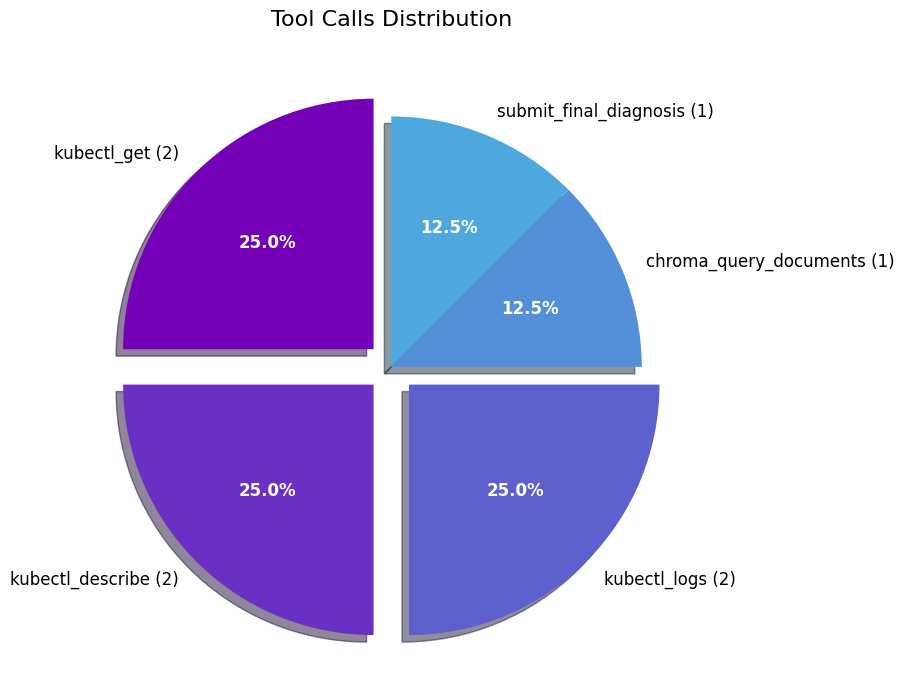

In [210]:
import matplotlib.pyplot as plt

# Create a better color palette with purple shades
colors = ['#7400B8', '#6930C3', '#5E60CE', '#5390D9', '#4EA8DE', '#48BFE3'][:len(tool_calls)]
# Create labels with tool name and count
labels = [f"{tool} ({count})" for tool, count in tool_calls.items()]

# Create an explode effect for the largest value
values = list(tool_calls.values())
explode = [0.1 if v == max(values) else 0 for v in values]

# Create the pie chart with improvements
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    values, 
    explode=explode,
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 12}
)

# Make the percentage text more visible
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title('Tool Calls Distribution', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [211]:
for step in structured_result["prev_steps"]:
    print(step)

Executed kubectl_get to list all pods across namespaces (kubectl get pods --all-namespaces -o wide) and collected pod statuses.
Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' (kubectl_describe) to inspect container state and events.
Ran kubectl_logs to tail 500 lines from container 'hotel-reserv-geo' in pod 'geo' (namespace test-hotel-reservation); the command failed with "Resource pod geo not found".
Ran kubectl_get (kubectl get pods --all-namespaces -o wide) to list pods and obtain the exact pod name and status.
Ran kubectl_describe on pod 'geo-6b4b89b5f5-d74mv' in namespace 'test-hotel-reservation' to inspect container state and events.
Ran kubectl_logs to fetch the last 500 lines from pod geo-6b4b89b5f5-d74mv in namespace test-hotel-reservation.
Queried the incident store with chroma_query_documents to retrieve a stored analysis confirming the MongoDB port/auth mismatch and suggested mitigations.


In [212]:
for insight in structured_result["insights"]:
    print(insight)

The pod test-hotel-reservation/geo is in CrashLoopBackOff (0/1) with 16 restarts (last restart ~4m52s ago) — the only failing pod in the cluster, indicating a repeated startup/crash symptom likely due to an application or init error.
The container hotel-reserv-geo is repeatedly crashing with LastState Terminated (Reason: Error) Exit Code 2, producing a CrashLoopBackOff despite successful image pulls — indicates an application startup/runtime error (not an image or scheduling issue); next step: fetch container logs to see the error output.
Attempt to fetch container logs failed: kubectl returned "Resource pod geo not found" — the pod cannot be located (may have been deleted/restarted with a different name), so we currently cannot access the crashing container's logs.
The failing pod is present as test-hotel-reservation/geo-6b4b89b5f5-d74mv (0/1, CrashLoopBackOff) with 17 restarts (last restart ~20s ago) — an active crashloop. We can now fetch logs using that exact pod name to diagnose t

In [213]:
print(structured_result["response"])

Diagnosis:
The geo service is crashing on startup because it is misconfigured to connect to MongoDB on the wrong port (27777) and lacking proper authentication/credentials; this causes connection failures (no reachable servers) and the application to panic and exit with code 2, resulting in a CrashLoopBackOff.

Reasoning:
Kubernetes pod status and restart counts show the geo container repeatedly fails on startup with Exit Code 2, which points to an application runtime error. The pod is scheduled and the image is pulled successfully, so it's not a scheduling or image issue. Application logs explicitly show a panic 'no reachable servers' while attempting to connect to mongodb-geo:27777. A prior incident document retrieved from the incident store confirms MongoDB listens on the default 27017 and requires authentication. Combining these facts indicates the geo service is configured with the wrong MongoDB port and likely missing credentials; the service cannot establish a DB connection, pan

In [214]:
print(structured_result["mitigation_plan_overview"])

Fix geo's MongoDB connection by correcting the port to 27017 and supplying credentials via a Kubernetes Secret; perform a rolling restart and verify. If immediate config change is not possible, use a short-lived service port mapping (mongodb-geo:27777 → 27017) as a temporary workaround. After recovery, apply remediation: Secrets, RBAC, CI checks, and improved startup resilience.


In [215]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_WFSiVuZPsQpEwCRpc8n7fFwr)
 Call ID: call_WFSiVuZPsQpEwCRpc8n7fFwr
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS         AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-qw2dt                                             0/1     Completed          0                67m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-66ffc                                   1/1     Running            0                75m   10.244.0.2    kind-control-plane   <none>           <none>
kube-system              co